In [1]:
# Import the required libraries

import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

In [2]:
# Create a pandas data frame with the data, then try to identify the features.
read_data = pd.read_csv('transaction_data.csv')
data = read_data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083818 entries, 0 to 1083817
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   UserId                  1083818 non-null  int64  
 1   TransactionId           1083818 non-null  int64  
 2   TransactionTime         1083818 non-null  object 
 3   ItemCode                1083818 non-null  int64  
 4   ItemDescription         1080910 non-null  object 
 5   NumberOfItemsPurchased  1083818 non-null  int64  
 6   CostPerItem             1083818 non-null  float64
 7   Country                 1083818 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 66.2+ MB


The features are described as follows:

UserID: Unique identification for a user.

TransactionId: A transaction's special identification number. All those products are purchased together in the single transaction if the same TransactionId appears in several rows.

TransactionTime: The time the transaction is carried out.

ItemCode: Special product identification code

ItemDescription: A brief explanation of the item you just bought

NumberOfItemsPurchased: The total number of items that were purchased in the transaction.

CostPerItem: The cost of the product for each unit.

Country: The nation from which the transaction is made.

In [3]:
# EDA and data cleaning

data = data[data.UserId>0] # usedid <=0 : 25%
data = data[data.ItemCode>0]
data = data[data.NumberOfItemsPurchased>0]
data = data[data.CostPerItem>0]
data = data[data.ItemDescription.notna()]
data = data[data.TransactionTime.str[-4:] != '2028']
data.head()

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
5,285957,6307136,Fri Jan 11 09:50:00 IST 2019,1787247,CUT GLASS T-LIGHT HOLDER OCTAGON,12,3.52,United Kingdom


C:\Users\hp\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


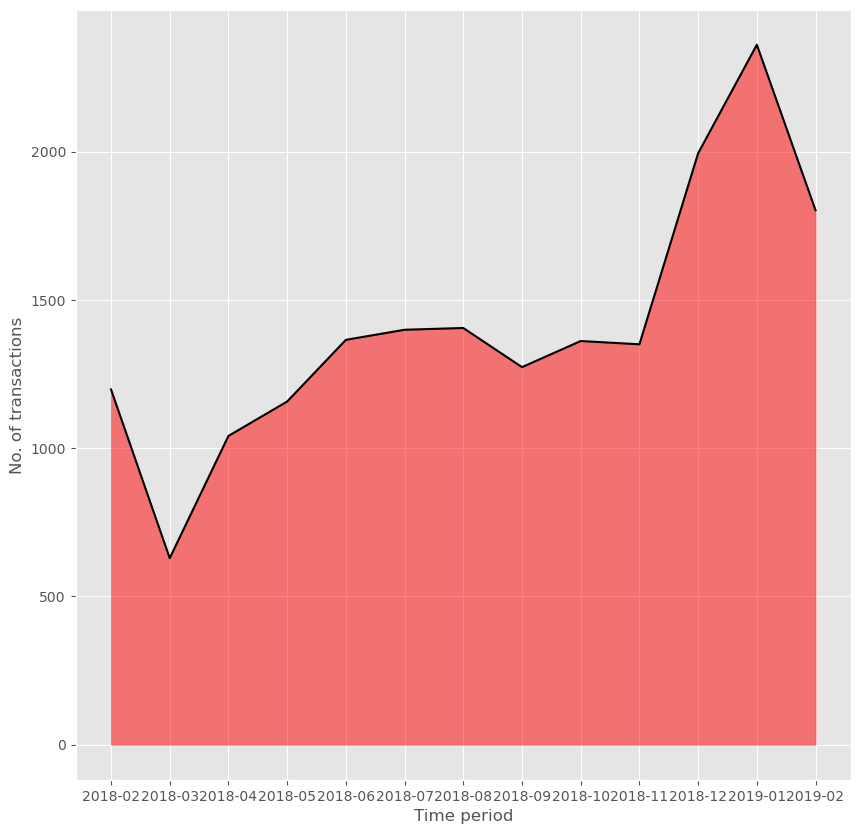

In [4]:
data.TransactionTime = pd.to_datetime(data.TransactionTime)
data['month_year']= pd.to_datetime(data.TransactionTime).dt.to_period('M')
data.sort_values(by = ['month_year'], inplace = True)
Ser = data.groupby('month_year').TransactionId.nunique()
x = np.arange(0,len(Ser),1)
style.use('ggplot')
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(111)
ax1.plot(x, Ser, color = 'k')
ax1.fill_between(x, Ser, color = 'r', alpha = 0.5)
ax1.set_xticks(x)
ax1.set_xticklabels(Ser.index)
plt.xlabel('Time period')
plt.ylabel('No. of transactions')
plt.show()

In order to categorize the data points according to the month in which they happened, we are basically adding a column called month_year. Then, using Matplotlib, we plot the number of unique transactions that occur each month.

In [5]:
Ser = data.groupby('TransactionId').ItemDescription.nunique()
Ser.describe()

count    18334.000000
mean        21.014236
std         23.838977
min          1.000000
25%          7.000000
50%         15.000000
75%         27.000000
max        540.000000
Name: ItemDescription, dtype: float64

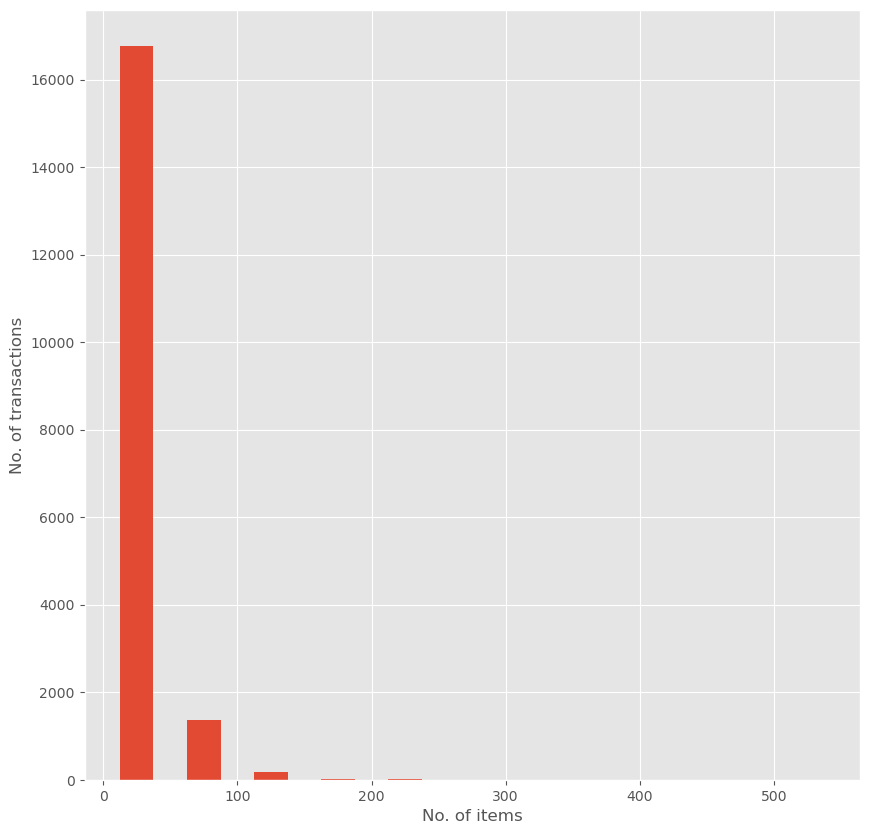

In [6]:
bins = [0,50,100,150,200,250,300,350,400,450,500,550]
fig = plt.figure(figsize = (10,10))
plt.hist(Ser, bins, histtype = 'bar', rwidth = 0.5)
plt.xlabel('No. of items')
plt.ylabel('No. of transactions')
plt.show()

We can see that the majority of the transactions consist of between 0-100 and 100-200 items. The maximum number of transactions indicated above is either an anomaly or represents a consumer that makes several purchases. Therefore, we must rescale our histogram.

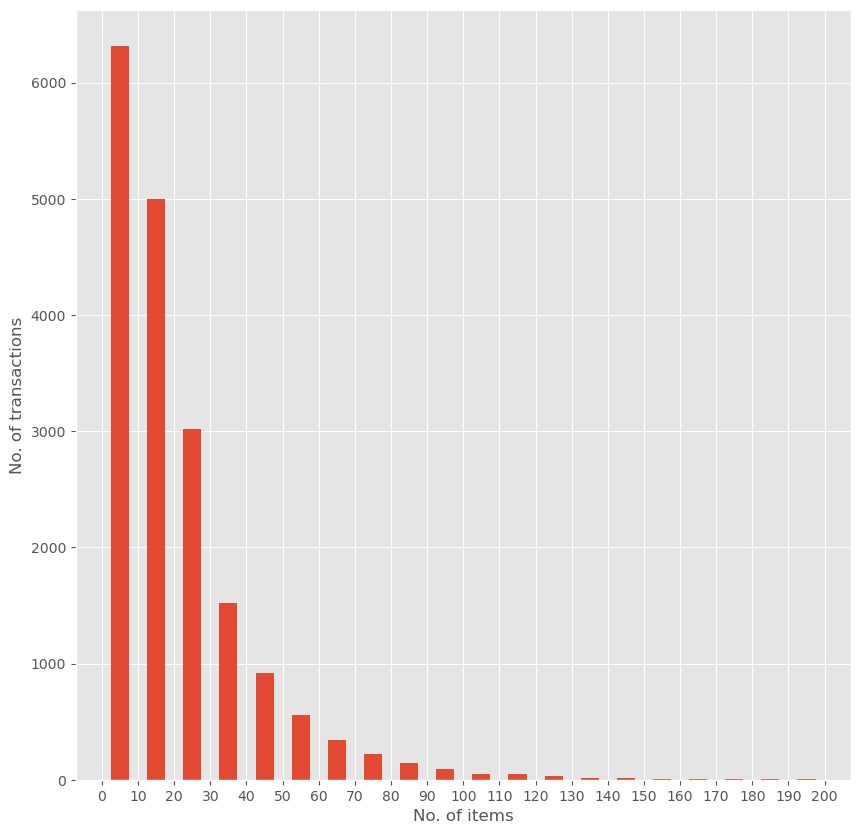

In [7]:
bins = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(111)
ax1.hist(Ser, bins, histtype = 'bar', rwidth = 0.5)
ax1.set_xticks(bins)
plt.xlabel('No. of items')
plt.ylabel('No. of transactions')
plt.show()

As you can see, the majority of transactions only featured nine or less goods.

Let's find out what is the most popular product on the market. This can be interpreted in a variety of ways, such as the item that generates the most income or the item 
that appears in the most transactions, etc. The things that generate the most revenue will be taken into consideration.

<BarContainer object of 10 artists>

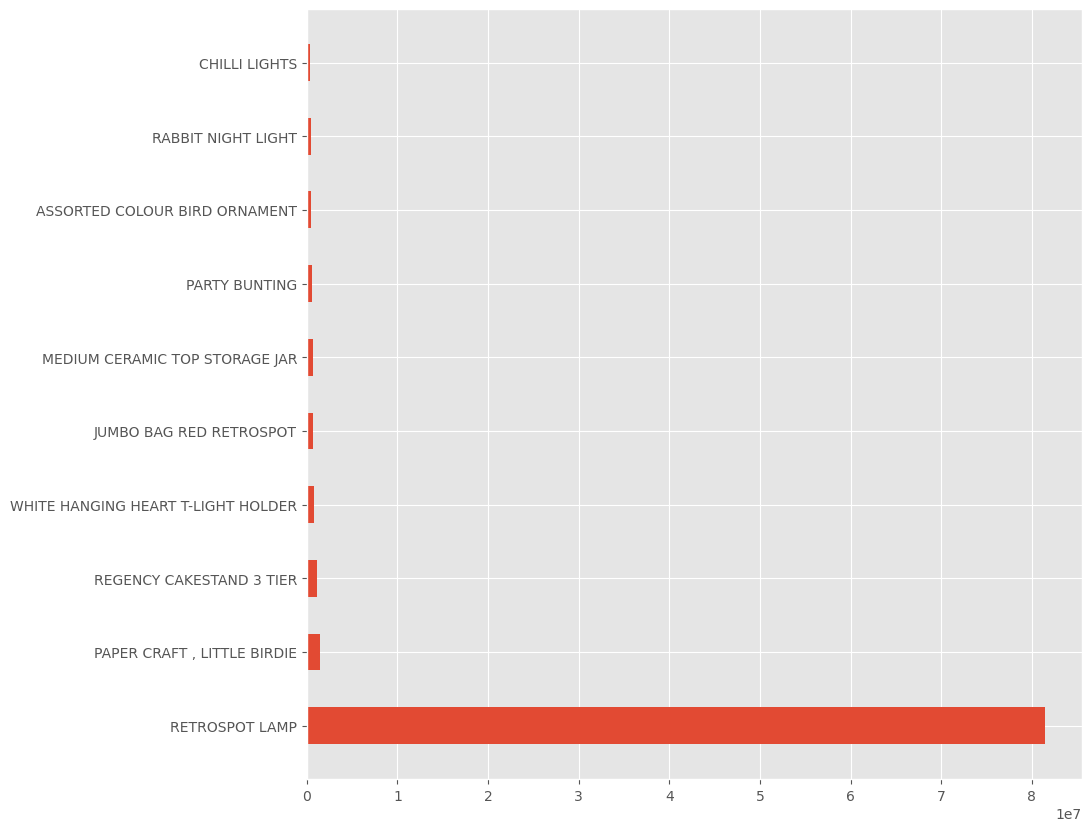

In [8]:
data['total_cost_item'] = data.NumberOfItemsPurchased*data.CostPerItem
Ser = data.groupby('ItemDescription').total_cost_item.sum()
Ser.sort_values(ascending = False, inplace = True)
Ser = Ser[:10]
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.barh(Ser.index, Ser, height = 0.5)

We can observe from the above plot of the top ten goods that the item'retrospot light' has the highest sales value.

The number of unique TransactionIds discovered is 18334, and the number of unique ItemDescriptions discovered is 3871.

Now that we have our data after all of the pre-processing, let's organise it using the TransactionIds as the index and the ItemDescriptions as columns, with the total number of things purchased in each transaction as the data-point.

In [9]:
data_set = data.groupby(['TransactionId', 'ItemDescription']).NumberOfItemsPurchased.sum().unstack().reset_index().fillna(0).set_index('TransactionId')
data_set

ItemDescription,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
TransactionId,,,,,,,,,,,,,,,,,,,,,
5900015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5900026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5900037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5900048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5900059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6397413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6397424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6397435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,72.0,0.0,0.0,0.0,144.0,0.0,0.0


We must ensure that all positive values are encoded as one and any negative values (if any) are encoded as zero.

In [10]:
def encode(x):
 if x <= 0:
     return 0
 else:
     return 1
data_set = data_set.applymap(encode)
data_set

ItemDescription,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
TransactionId,,,,,,,,,,,,,,,,,,,,,
5900015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5900026,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5900037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5900048,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5900059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6397413,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6397424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6397435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


Apply Apriori algorithm to get the frequently bought item-sets.

In [11]:
frequent_item = apriori(data_set, min_support = 0.015, use_colnames = True)



C:\Users\hp\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


C:\Users\hp\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_20276\1489032430.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_items.itemsets.iloc[i] = str(list(top_items.itemsets.iloc[i]))


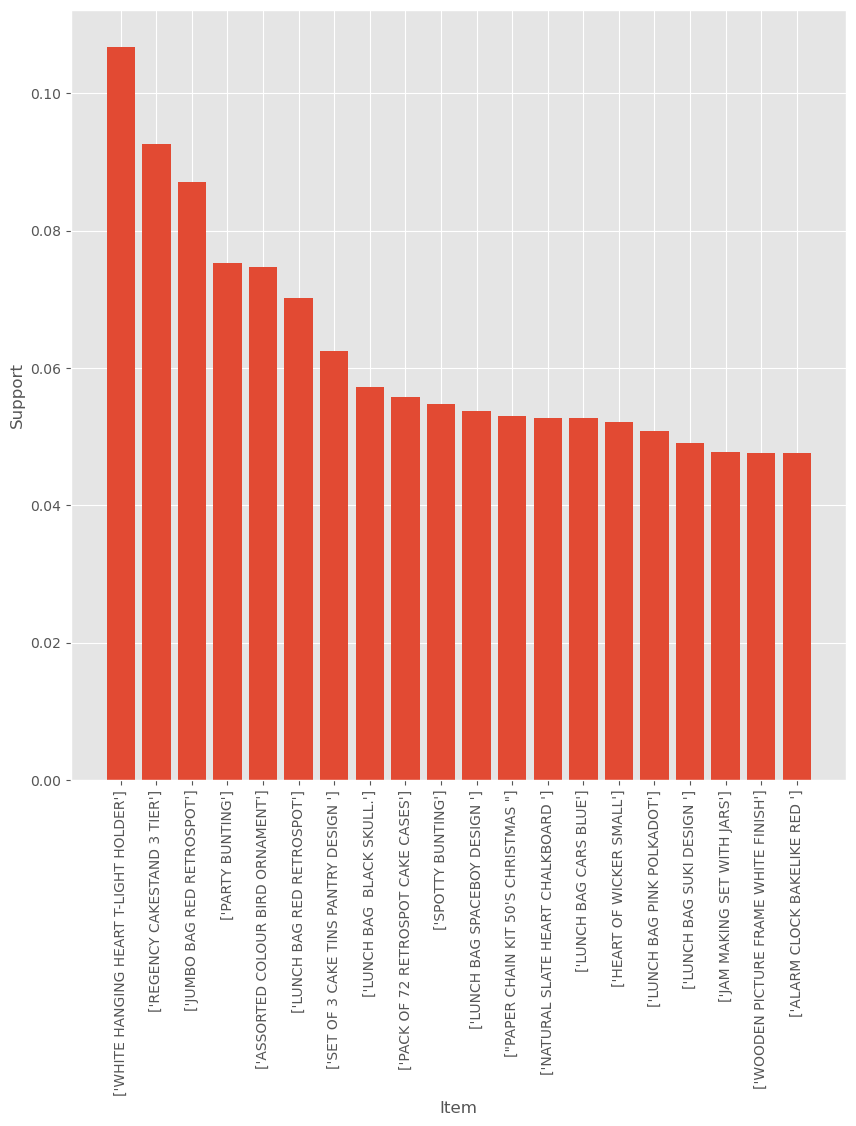

In [12]:
frequent_item = apriori(data_set, min_support = 0.015, use_colnames = True)
top_items = frequent_item.sort_values('support', ascending = False)[:20]
for i in range(len(top_items.itemsets)):
    top_items.itemsets.iloc[i] = str(list(top_items.itemsets.iloc[i]))
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.bar(top_items.itemsets, top_items.support)
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(90)
plt.xlabel('Item')
plt.ylabel('Support')
plt.show()

In [13]:
rules = association_rules(frequent_item, metric = 'confidence', min_threshold = 0.2)

The summary of the rules data-frames reveals the following:

There are 187 rules in all.
The following is a summary of several measures.


In [14]:
top_rules = rules.sort_values('confidence', ascending = False)[:10]
top_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
166,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",(GREEN REGENCY TEACUP AND SAUCER),0.023781,0.037690,0.021272,0.894495,23.733255,0.020376,9.121030
165,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.025090,0.042653,0.021272,0.847826,19.877293,0.020202,6.291137
170,"(GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...",(ROSES REGENCY TEACUP AND SAUCER ),0.020399,0.042653,0.017018,0.834225,19.558406,0.016147,5.774964
25,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.030326,0.037690,0.025090,0.827338,21.951400,0.023947,5.573381
146,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.030326,0.042653,0.023781,0.784173,18.384938,0.022487,4.435708
28,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.037690,0.042653,0.029508,0.782923,18.355647,0.027900,4.410179
172,"(REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACU...",(GREEN REGENCY TEACUP AND SAUCER),0.022854,0.037690,0.017018,0.744630,19.756943,0.016156,3.768300
162,(WOODEN STAR CHRISTMAS SCANDINAVIAN),(WOODEN HEART CHRISTMAS SCANDINAVIAN),0.023563,0.025199,0.017345,0.736111,29.211821,0.016751,3.693982
12,(BAKING SET SPACEBOY DESIGN),(BAKING SET 9 PIECE RETROSPOT ),0.023126,0.046580,0.016963,0.733491,15.746857,0.015886,3.577434
22,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.034635,0.041235,0.025254,0.729134,17.682461,0.023825,3.539627


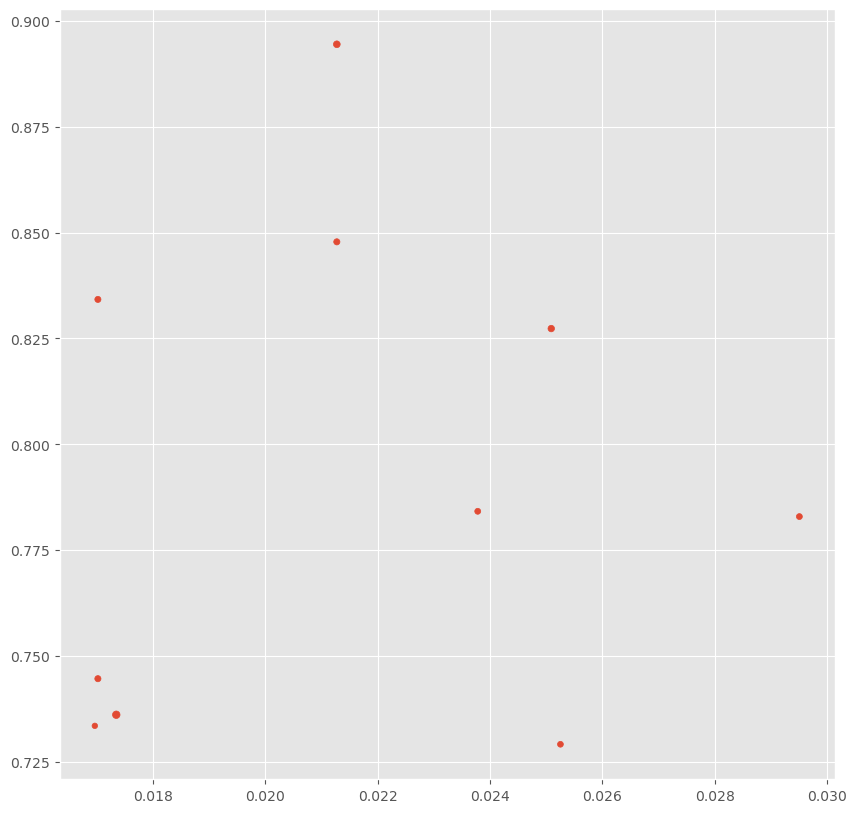

In [15]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.scatter(top_rules.support, top_rules.confidence, top_rules.lift)

import networkx as nx
G1 = nx.DiGraph()
color_map = []
N = 50
colors = np.random.rand(N)
strs = ['r0', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9']
for i in range(10):
    G1.add_nodes_from('r'+str(i))
    for a in top_rules.iloc[i]['antecedents']:
        G1.add_nodes_from([a])
        G1.add_edge(a, 'r'+str(i), color = colors[i], weight = 2)
    for c in top_rules.iloc[i]['consequents']:
        G1.add_nodes_from([c])
        G1.add_edge('r'+str(i), c, color = colors[i], weight = 2)
for node in G1:
    found_a_string = False
    for item in strs:
        if node == item:
            found_a_string = True
    if found_a_string:
        color_map.append('red')
    else:
        color_map.append('black')
edges = G1.edges()
colors = [G1[u][v]['color'] for u,v in edges]
weights = [G1[u][v]['weight'] for u,v in edges]
pos = nx.spring_layout(G1, k = 16, scale = 1)
fig = plt.figure(figsize = (20,20))
nx.draw(G1, pos, edges = edges, node_color = color_map, edge_color = colors, width = weights, font_size = 16, with_labels = False)
for p in pos:
    pos[p][1] += 0.07
nx.draw_networkx_labels(G1, pos)

In [16]:
rules[(rules.lift >= 9.388) & (rules.confidence >= 0.429)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.033272,0.042817,0.018545,0.557377,13.017772,0.017120,2.162525
5,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.042817,0.033272,0.018545,0.433121,13.017772,0.017120,1.705352
6,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.042817,0.047562,0.028744,0.671338,14.115027,0.026708,2.897922
7,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.047562,0.042817,0.028744,0.604358,14.115027,0.026708,2.419316
8,(ALARM CLOCK BAKELIKE IVORY),(ALARM CLOCK BAKELIKE RED ),0.025363,0.047562,0.017018,0.670968,14.107251,0.015811,2.894665
10,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED ),0.033272,0.047562,0.021436,0.644262,13.545763,0.019853,2.677361
11,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE PINK),0.047562,0.033272,0.021436,0.450688,13.545763,0.019853,1.759890
12,(BAKING SET SPACEBOY DESIGN),(BAKING SET 9 PIECE RETROSPOT ),0.023126,0.046580,0.016963,0.733491,15.746857,0.015886,3.577434
14,(RED RETROSPOT CHARLOTTE BAG),(CHARLOTTE BAG PINK POLKADOT),0.040253,0.026508,0.017508,0.434959,16.408528,0.016441,1.722871
15,(CHARLOTTE BAG PINK POLKADOT),(RED RETROSPOT CHARLOTTE BAG),0.026508,0.040253,0.017508,0.660494,16.408528,0.016441,2.826891


All of the essential item-sets may be discovered in this manner. By adjusting the threshold values of support and lift, the item-sets may be fine-tuned further to locate the most likely ones. 